# Lesson 5: Adding Relationships to the SEC Knowledge Graph

First we will create form10 k node

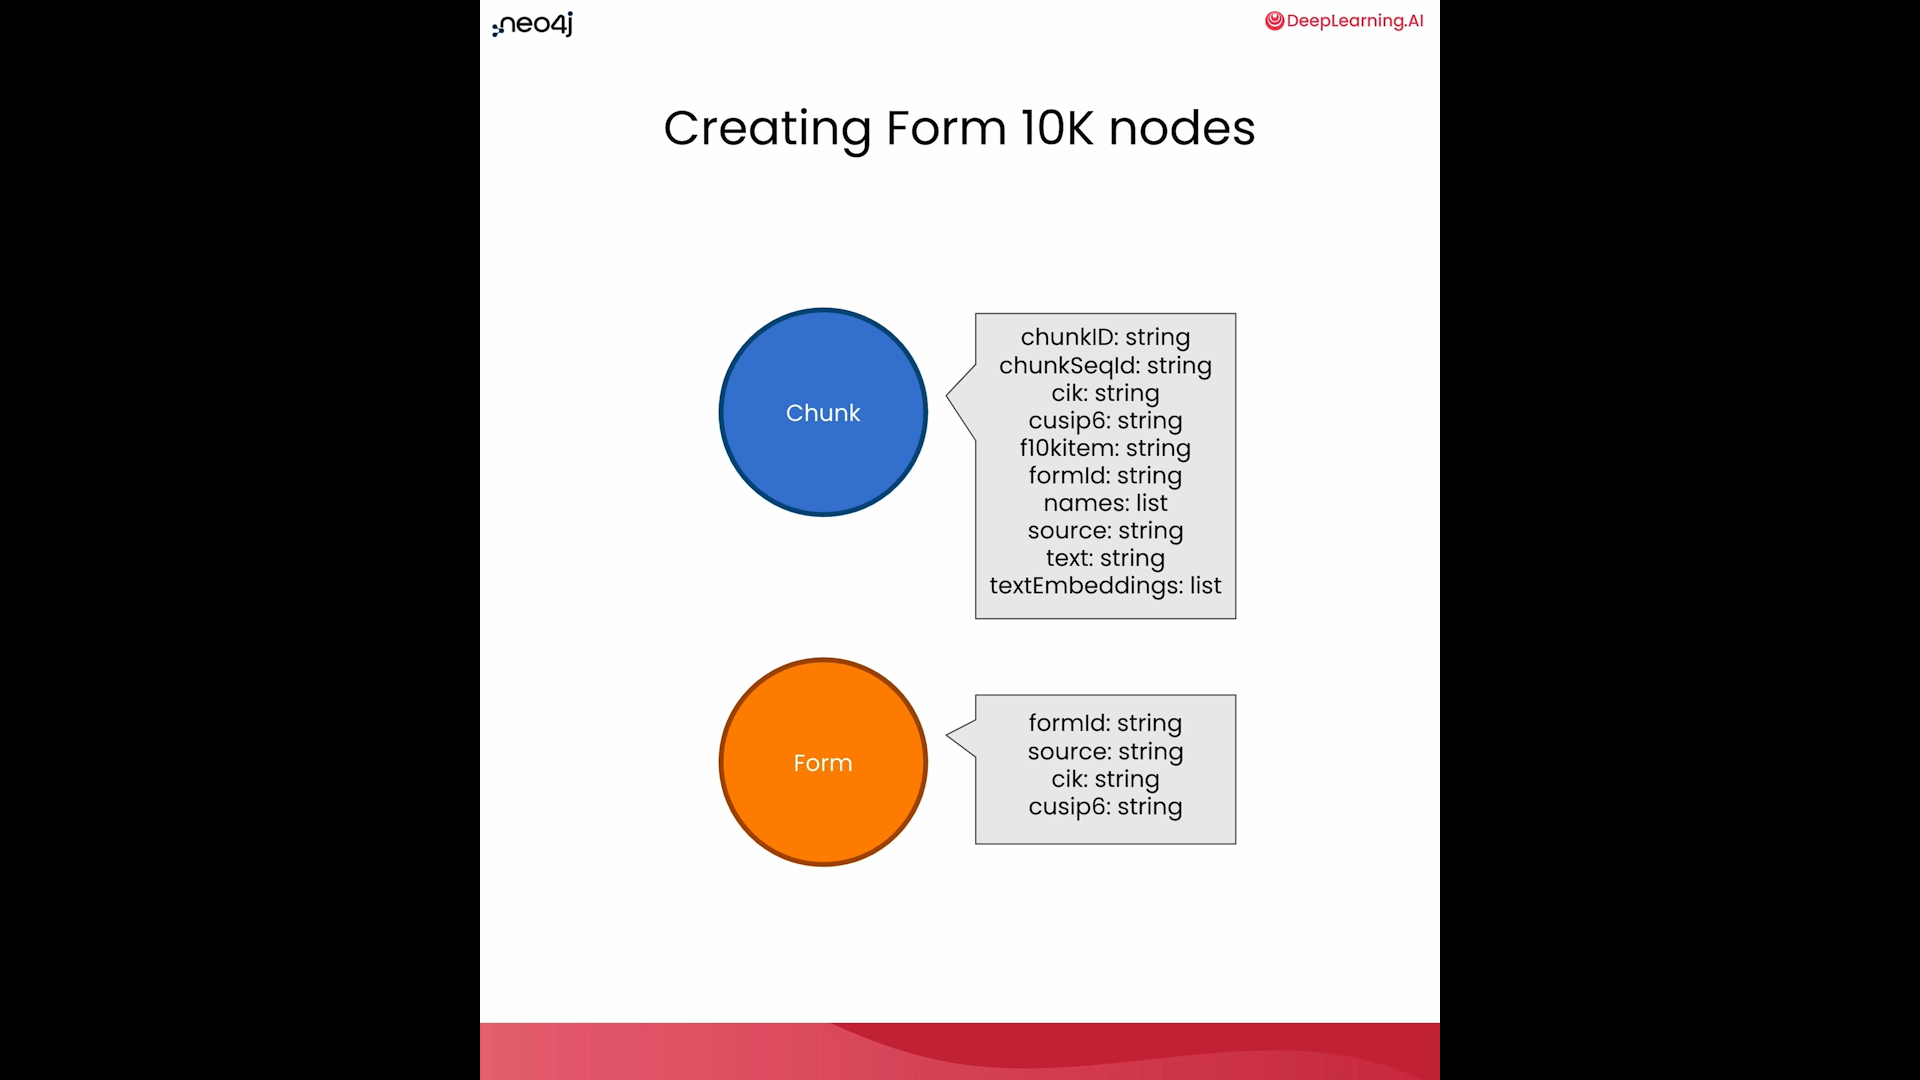

<p style="background-color:#fd4a6180; padding:15px; margin-left:20px"> <b>Note:</b> This notebook takes about 30 seconds to be ready to use. Please wait until the "Kernel starting, please wait..." message clears from the top of the notebook before running any cells. You may start the video while you wait.</p>

### Import packages and set up Neo4j

In [1]:
from dotenv import load_dotenv
import os

# Common data processing
import textwrap

# Langchain
from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQAWithSourcesChain
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

# Warning control
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load from environment
load_dotenv('.env', override=True)
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE') or 'neo4j'

# Global constants
VECTOR_INDEX_NAME = 'form_10k_chunks'
VECTOR_NODE_LABEL = 'Chunk'
VECTOR_SOURCE_PROPERTY = 'text'
VECTOR_EMBEDDING_PROPERTY = 'textEmbedding'


In [3]:
kg = Neo4jGraph(
    url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE
)

### Create a Form 10-K node
- Create a node to represent the entire Form 10-K
- Populate with metadata taken from a single chunk of the form

In [5]:
cypher = """
  MATCH (anyChunk:Chunk) 
  WITH anyChunk LIMIT 1
  RETURN anyChunk { .names, .source, .formId, .cik, .cusip6 } as formInfo
"""
form_info_list = kg.query(cypher)

form_info_list


[{'formInfo': {'cik': '1002047',
   'source': 'https://www.sec.gov/Archives/edgar/data/1002047/000095017023027948/0000950170-23-027948-index.htm',
   'formId': '0000950170-23-027948',
   'names': ['Netapp Inc', 'NETAPP INC'],
   'cusip6': '64110D'}}]

In [6]:
form_info = form_info_list[0]['formInfo']

In [7]:
form_info

{'cik': '1002047',
 'source': 'https://www.sec.gov/Archives/edgar/data/1002047/000095017023027948/0000950170-23-027948-index.htm',
 'formId': '0000950170-23-027948',
 'names': ['Netapp Inc', 'NETAPP INC'],
 'cusip6': '64110D'}

In [8]:
cypher = """
    MERGE (f:Form {formId: $formInfoParam.formId })
      ON CREATE 
        SET f.names = $formInfoParam.names
        SET f.source = $formInfoParam.source
        SET f.cik = $formInfoParam.cik
        SET f.cusip6 = $formInfoParam.cusip6
"""

kg.query(cypher, params={'formInfoParam': form_info})

[]

In [9]:
kg.query("MATCH (f:Form) RETURN count(f) as formCount")

[{'formCount': 1}]

### Create a linked list of Chunk nodes for each section
- Start by identifying chunks from the same section

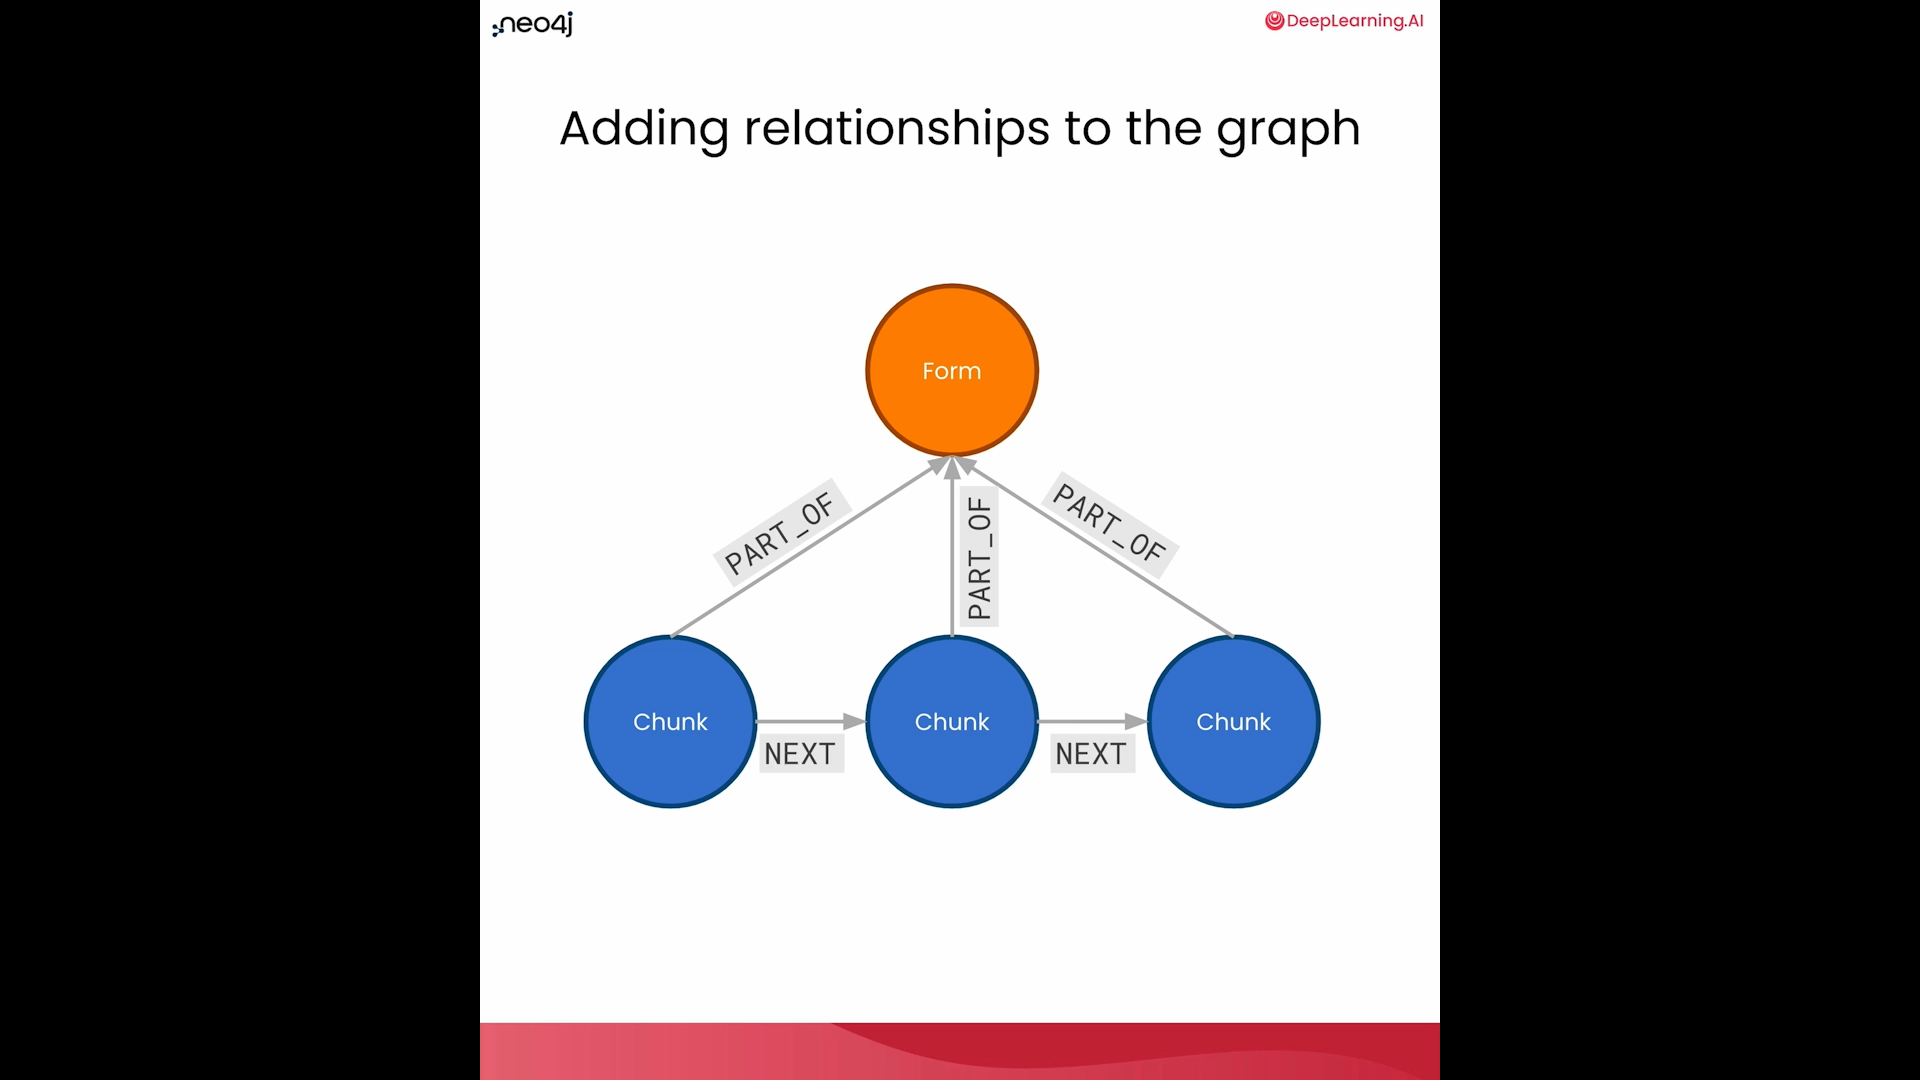

Identify all chunks which comes from same formid

In [10]:
cypher = """
  MATCH (from_same_form:Chunk)
    WHERE from_same_form.formId = $formIdParam
  RETURN from_same_form {.formId, .f10kItem, .chunkId, .chunkSeqId } as chunkInfo
    LIMIT 10
"""

kg.query(cypher, params={'formIdParam': form_info['formId']})

[{'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0000',
   'chunkSeqId': 0}},
 {'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0001',
   'chunkSeqId': 1}},
 {'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0002',
   'chunkSeqId': 2}},
 {'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0003',
   'chunkSeqId': 3}},
 {'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0004',
   'chunkSeqId': 4}},
 {'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0005',
   'chunkSeqId': 5}},
 {'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-

- Order chunks by their sequence ID

In [11]:
cypher = """
  MATCH (from_same_form:Chunk)
    WHERE from_same_form.formId = $formIdParam
  RETURN from_same_form {.formId, .f10kItem, .chunkId, .chunkSeqId } as chunkInfo 
    ORDER BY from_same_form.chunkSeqId ASC
    LIMIT 10
"""

kg.query(cypher, params={'formIdParam': form_info['formId']})

[{'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item7a',
   'chunkId': '0000950170-23-027948-item7a-chunk0000',
   'chunkSeqId': 0}},
 {'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item7',
   'chunkId': '0000950170-23-027948-item7-chunk0000',
   'chunkSeqId': 0}},
 {'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1a',
   'chunkId': '0000950170-23-027948-item1a-chunk0000',
   'chunkSeqId': 0}},
 {'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0000',
   'chunkSeqId': 0}},
 {'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0001',
   'chunkSeqId': 1}},
 {'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0002',
   'chunkSeqId': 2}},
 {'chunkInfo': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950

Now if you see above result . We will have chunseqId - 0 multiple times because it is from different sections . Item7a , item 7 , item1a

- Limit chunks to just the "Item 1" section, the organize in ascending order

In [12]:
cypher = """
  MATCH (from_same_section:Chunk)
  WHERE from_same_section.formId = $formIdParam
    AND from_same_section.f10kItem = $f10kItemParam // NEW!!!
  RETURN from_same_section { .formId, .f10kItem, .chunkId, .chunkSeqId } 
    ORDER BY from_same_section.chunkSeqId ASC
    LIMIT 10
"""

kg.query(cypher, params={'formIdParam': form_info['formId'], 
                         'f10kItemParam': 'item1'})


[{'from_same_section': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0000',
   'chunkSeqId': 0}},
 {'from_same_section': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0001',
   'chunkSeqId': 1}},
 {'from_same_section': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0002',
   'chunkSeqId': 2}},
 {'from_same_section': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0003',
   'chunkSeqId': 3}},
 {'from_same_section': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0004',
   'chunkSeqId': 4}},
 {'from_same_section': {'formId': '0000950170-23-027948',
   'f10kItem': 'item1',
   'chunkId': '0000950170-23-027948-item1-chunk0005',
   'chunkSeqId': 5}},
 {'from_same_section': {'formId': '0000950170-23-027

- Collect ordered chunks into a list

In [13]:
cypher = """
  MATCH (from_same_section:Chunk)
  WHERE from_same_section.formId = $formIdParam
    AND from_same_section.f10kItem = $f10kItemParam
  WITH from_same_section { .formId, .f10kItem, .chunkId, .chunkSeqId } 
    ORDER BY from_same_section.chunkSeqId ASC
    LIMIT 10
  RETURN collect(from_same_section) // NEW!!!
"""

kg.query(cypher, params={'formIdParam': form_info['formId'], 
                         'f10kItemParam': 'item1'})


[{'collect(from_same_section)': [{'formId': '0000950170-23-027948',
    'f10kItem': 'item1',
    'chunkId': '0000950170-23-027948-item1-chunk0000',
    'chunkSeqId': 0},
   {'formId': '0000950170-23-027948',
    'f10kItem': 'item1',
    'chunkId': '0000950170-23-027948-item1-chunk0001',
    'chunkSeqId': 1},
   {'formId': '0000950170-23-027948',
    'f10kItem': 'item1',
    'chunkId': '0000950170-23-027948-item1-chunk0002',
    'chunkSeqId': 2},
   {'formId': '0000950170-23-027948',
    'f10kItem': 'item1',
    'chunkId': '0000950170-23-027948-item1-chunk0003',
    'chunkSeqId': 3},
   {'formId': '0000950170-23-027948',
    'f10kItem': 'item1',
    'chunkId': '0000950170-23-027948-item1-chunk0004',
    'chunkSeqId': 4},
   {'formId': '0000950170-23-027948',
    'f10kItem': 'item1',
    'chunkId': '0000950170-23-027948-item1-chunk0005',
    'chunkSeqId': 5},
   {'formId': '0000950170-23-027948',
    'f10kItem': 'item1',
    'chunkId': '0000950170-23-027948-item1-chunk0006',
    'chunkSe

### Add a NEXT relationship between subsequent chunks
- Use the `apoc.nodes.link` function from Neo4j to link ordered list of `Chunk` nodes with a `NEXT` relationship
- Do this for just the "Item 1" section to start

This will create a linked list for all the chunks present in collected list output 

In [15]:
cypher = """
  MATCH (from_same_section:Chunk)
  WHERE from_same_section.formId = $formIdParam
    AND from_same_section.f10kItem = $f10kItemParam
  WITH from_same_section
    ORDER BY from_same_section.chunkSeqId ASC
  WITH collect(from_same_section) as section_chunk_list
    CALL apoc.nodes.link(
        section_chunk_list, 
        "NEXT", 
        {avoidDuplicates: true}
    )  // NEW!!!
  RETURN size(section_chunk_list)
"""

kg.query(cypher, params={'formIdParam': form_info['formId'], 
                         'f10kItemParam': 'item1'})


[{'size(section_chunk_list)': 20}]

In [16]:
kg.refresh_schema()
print(kg.schema)

Node properties are the following:
Chunk {textEmbedding: LIST, f10kItem: STRING, chunkSeqId: INTEGER, text: STRING, cik: STRING, cusip6: STRING, names: LIST, formId: STRING, source: STRING, chunkId: STRING},Form {cik: STRING, cusip6: STRING, names: LIST, formId: STRING, source: STRING}
Relationship properties are the following:

The relationships are the following:
(:Chunk)-[:NEXT]->(:Chunk)


- Loop through and create relationships for all sections of the form 10-K

In [18]:
cypher = """
  MATCH (from_same_section:Chunk)
  WHERE from_same_section.formId = $formIdParam
    AND from_same_section.f10kItem = $f10kItemParam
  WITH from_same_section
    ORDER BY from_same_section.chunkSeqId ASC
  WITH collect(from_same_section) as section_chunk_list
    CALL apoc.nodes.link(
        section_chunk_list, 
        "NEXT", 
        {avoidDuplicates: true}
    )
  RETURN size(section_chunk_list)
"""
for form10kItemName in ['item1', 'item1a', 'item7', 'item7a']:
  kg.query(cypher, params={'formIdParam':form_info['formId'], 
                           'f10kItemParam': form10kItemName})


### Connect chunks to their parent form with a PART_OF relationship

In [19]:
cypher = """
  MATCH (c:Chunk), (f:Form)
    WHERE c.formId = f.formId
  MERGE (c)-[newRelationship:PART_OF]->(f)
  RETURN count(newRelationship)
"""

kg.query(cypher)

[{'count(newRelationship)': 23}]

### Create a SECTION relationship on first chunk of each section

Will create 4 sections . And each section will then have chunks attached 

In [20]:
cypher = """
  MATCH (first:Chunk), (f:Form)
  WHERE first.formId = f.formId
    AND first.chunkSeqId = 0
  WITH first, f
    MERGE (f)-[r:SECTION {f10kItem: first.f10kItem}]->(first)
  RETURN count(r)
"""

kg.query(cypher)

[{'count(r)': 4}]

### Example cypher queries
- Return the first chunk of the Item 1 section

In [21]:
cypher = """
  MATCH (f:Form)-[r:SECTION]->(first:Chunk)
    WHERE f.formId = $formIdParam
        AND r.f10kItem = $f10kItemParam
  RETURN first.chunkId as chunkId, first.text as text
"""

first_chunk_info = kg.query(cypher, params={
    'formIdParam': form_info['formId'], 
    'f10kItemParam': 'item1'
})[0]

first_chunk_info


{'chunkId': '0000950170-23-027948-item1-chunk0000',
 'text': '>Item 1.  \nBusiness\n\n\nOverview\n\n\nNetApp, Inc. (NetApp, we, us or the Company) is a global cloud-led, data-centric software company. We were incorporated in 1992 and are headquartered in San Jose, California. Building on more than three decades of innovation, we give customers the freedom to manage applications and data across hybrid multicloud environments. Our portfolio of cloud services, and storage infrastructure, powered by intelligent data management software, enables applications to run faster, more reliably, and more securely, all at a lower cost.\n\n\nOur opportunity is defined by the durable megatrends of data-driven digital and cloud transformations. NetApp helps organizations meet the complexities created by rapid data and cloud growth, multi-cloud management, and the adoption of next-generation technologies, such as AI, Kubernetes, and modern databases. Our modern approach to hybrid, multicloud infrastruct

- Get the second chunk of the Item 1 section

Since it is linked list. SO with information of 1st chunk . We can get next chunk as well.

In [22]:
cypher = """
  MATCH (first:Chunk)-[:NEXT]->(nextChunk:Chunk)
    WHERE first.chunkId = $chunkIdParam
  RETURN nextChunk.chunkId as chunkId, nextChunk.text as text
"""

next_chunk_info = kg.query(cypher, params={
    'chunkIdParam': first_chunk_info['chunkId']
})[0]

next_chunk_info


{'chunkId': '0000950170-23-027948-item1-chunk0001',
 'text': "•\nFlexibility and consistency: NetApp makes moving data and applications between environments seamless through a common storage foundation across on-premises and multicloud environments.\n\n\n•\nCyber resilience: NetApp unifies monitoring, data protection, security, governance, and compliance for total cyber resilience - with consistency and automation across environments. \n\n\n•\nContinuous operations: NetApp uses AI-driven automation for continuous optimization to service applications and store stateless and stateful applications at the lowest possible costs.\n\n\n•\nSustainability: NetApp has industry-leading tools to audit consumption, locate waste, and set guardrails to stop overprovisioning.\n\n\nProduct, Solutions and Services Portfolio\n \n\n\nNetApp's portfolio of cloud services and storage infrastructure is powered by intelligent data management software. Our operations are organized into two segments: Hybrid Clo

In [23]:
print(first_chunk_info['chunkId'], next_chunk_info['chunkId'])

0000950170-23-027948-item1-chunk0000 0000950170-23-027948-item1-chunk0001


- Return a window of three chunks

In [24]:
cypher = """
    MATCH (c1:Chunk)-[:NEXT]->(c2:Chunk)-[:NEXT]->(c3:Chunk) 
        WHERE c2.chunkId = $chunkIdParam
    RETURN c1.chunkId, c2.chunkId, c3.chunkId
    """

kg.query(cypher,
         params={'chunkIdParam': next_chunk_info['chunkId']})

[{'c1.chunkId': '0000950170-23-027948-item1-chunk0000',
  'c2.chunkId': '0000950170-23-027948-item1-chunk0001',
  'c3.chunkId': '0000950170-23-027948-item1-chunk0002'}]

### Information is stored in the structure of a graph
- Matched patterns of nodes and relationships in a graph are called **paths**
- The length of a path is equal to the number of relationships in the path
- Paths can be captured as variables and used elsewhere in queries

Since we have 3 nodes , path will be 2

In [25]:
cypher = """
    MATCH window = (c1:Chunk)-[:NEXT]->(c2:Chunk)-[:NEXT]->(c3:Chunk) 
        WHERE c1.chunkId = $chunkIdParam
    RETURN length(window) as windowPathLength
    """

kg.query(cypher,
         params={'chunkIdParam': next_chunk_info['chunkId']})

[{'windowPathLength': 2}]

### Finding variable length windows
- A pattern match will fail if the relationship doesn't exist in the graph
- For example, the first chunk in a section has no preceding chunk, so the next query won't return anything

In [26]:
cypher = """
    MATCH window=(c1:Chunk)-[:NEXT]->(c2:Chunk)-[:NEXT]->(c3:Chunk) 
        WHERE c2.chunkId = $chunkIdParam
    RETURN nodes(window) as chunkList
    """
# pull the chunk ID from the first 
kg.query(cypher,
         params={'chunkIdParam': first_chunk_info['chunkId']})


[]

- Modify `NEXT` relationship to have variable length

:NEXT*0..1 ----- O is min no of relationship , 1 is max no of relationship

So now it will work for 0 and 1 

In [27]:
cypher = """
  MATCH window=
      (:Chunk)-[:NEXT*0..1]->(c:Chunk)-[:NEXT*0..1]->(:Chunk) 
    WHERE c.chunkId = $chunkIdParam
  RETURN length(window)
  """

kg.query(cypher,
         params={'chunkIdParam': first_chunk_info['chunkId']})

[{'length(window)': 0}, {'length(window)': 1}]

- Retrieve only the longest path

In [28]:
cypher = """
  MATCH window=
      (:Chunk)-[:NEXT*0..1]->(c:Chunk)-[:NEXT*0..1]->(:Chunk)
    WHERE c.chunkId = $chunkIdParam
  WITH window as longestChunkWindow 
      ORDER BY length(window) DESC LIMIT 1
  RETURN length(longestChunkWindow)
  """

kg.query(cypher,
         params={'chunkIdParam': first_chunk_info['chunkId']})

[{'length(longestChunkWindow)': 1}]

### Customize the results of the similarity search using Cypher
- Extend the vector store definition to accept a Cypher query
- The Cypher query takes the results of the vector similarity search and then modifies them in some way
- Start with a simple query that just returns some extra text along with the search results

In [29]:
retrieval_query_extra_text = """
WITH node, score, "Andreas knows Cypher. " as extraText
RETURN extraText + "\n" + node.text as text,
    score,
    node {.source} AS metadata
"""

- Set up the vector store to use the query, then instantiate a retriever and Question-Answer chain in LangChain


In [30]:
vector_store_extra_text = Neo4jVector.from_existing_index(
    embedding=OpenAIEmbeddings(),
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database="neo4j",
    index_name=VECTOR_INDEX_NAME,
    text_node_property=VECTOR_SOURCE_PROPERTY,
    retrieval_query=retrieval_query_extra_text, # NEW !!! Extension of vector seach
)

# Create a retriever from the vector store
retriever_extra_text = vector_store_extra_text.as_retriever()

# Create a chatbot Question & Answer chain from the retriever
chain_extra_text = RetrievalQAWithSourcesChain.from_chain_type(
    ChatOpenAI(temperature=0), 
    chain_type="stuff", 
    retriever=retriever_extra_text
)

- Ask a question!

In [31]:
chain_extra_text(
    {"question": "What topics does Andreas know about?"},
    return_only_outputs=True)

{'answer': 'Andreas knows about Cypher, Human Capital, Diversity, Inclusion, and Belonging, Benefits, Wellbeing, and Engagement.\n',
 'sources': 'https://www.sec.gov/Archives/edgar/data/1002047/000095017023027948/0000950170-23-027948-index.htm'}

- Note, the LLM hallucinates here, using the information in the retrieved text as well as the extra text.
- Modify the prompt to try and get a more accurate answer

In [32]:
chain_extra_text(
    {"question": "What single topic does Andreas know about?"},
    return_only_outputs=True)

{'answer': 'Andreas knows about Cypher.\n',
 'sources': 'https://www.sec.gov/Archives/edgar/data/1002047/000095017023027948/0000950170-23-027948-index.htm'}

### Try for yourself!
- Modify the query below to add your own additional text
- Try engineering the prompt to refine your results
- Note, you'll need to reset the vector store, retriever, and chain each time you change the Cypher query.

In [33]:
# modify the retrieval extra text here then run the entire cell
retrieval_query_extra_text = """
WITH node, score, "Andreas knows Cypher. " as extraText
RETURN extraText + "\n" + node.text as text,
    score,
    node {.source} AS metadata
"""

vector_store_extra_text = Neo4jVector.from_existing_index(
    embedding=OpenAIEmbeddings(),
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database="neo4j",
    index_name=VECTOR_INDEX_NAME,
    text_node_property=VECTOR_SOURCE_PROPERTY,
    retrieval_query=retrieval_query_extra_text, # NEW !!!
)

# Create a retriever from the vector store
retriever_extra_text = vector_store_extra_text.as_retriever()

# Create a chatbot Question & Answer chain from the retriever
chain_extra_text = RetrievalQAWithSourcesChain.from_chain_type(
    ChatOpenAI(temperature=0), 
    chain_type="stuff", 
    retriever=retriever_extra_text
)

### Expand context around a chunk using a window
- First, create a regular vector store that retrieves a single node

In [34]:
neo4j_vector_store = Neo4jVector.from_existing_graph(
    embedding=OpenAIEmbeddings(),
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name=VECTOR_INDEX_NAME,
    node_label=VECTOR_NODE_LABEL,
    text_node_properties=[VECTOR_SOURCE_PROPERTY],
    embedding_node_property=VECTOR_EMBEDDING_PROPERTY,
)
# Create a retriever from the vector store
windowless_retriever = neo4j_vector_store.as_retriever()

# Create a chatbot Question & Answer chain from the retriever
windowless_chain = RetrievalQAWithSourcesChain.from_chain_type(
    ChatOpenAI(temperature=0), 
    chain_type="stuff", 
    retriever=windowless_retriever
)

- Next, define a window retrieval query to get consecutive chunks
extend the context with adjacent chunks

In [35]:
retrieval_query_window = """
MATCH window=
    (:Chunk)-[:NEXT*0..1]->(node)-[:NEXT*0..1]->(:Chunk)
WITH node, score, window as longestWindow 
  ORDER BY length(window) DESC LIMIT 1
WITH nodes(longestWindow) as chunkList, node, score
  UNWIND chunkList as chunkRows
WITH collect(chunkRows.text) as textList, node, score
RETURN apoc.text.join(textList, " \n ") as text,
    score,
    node {.source} AS metadata
"""


- Set up a QA chain that will use the window retrieval query

In [36]:
vector_store_window = Neo4jVector.from_existing_index(
    embedding=OpenAIEmbeddings(),
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database="neo4j",
    index_name=VECTOR_INDEX_NAME,
    text_node_property=VECTOR_SOURCE_PROPERTY,
    retrieval_query=retrieval_query_window, # NEW!!!
)

# Create a retriever from the vector store
retriever_window = vector_store_window.as_retriever()

# Create a chatbot Question & Answer chain from the retriever
chain_window = RetrievalQAWithSourcesChain.from_chain_type(
    ChatOpenAI(temperature=0), 
    chain_type="stuff", 
    retriever=retriever_window
)

### Compare the two chains

In [37]:
question = "In a single sentence, tell me about Netapp's business."

In [38]:
answer = windowless_chain(
    {"question": question},
    return_only_outputs=True,
)
print(textwrap.fill(answer["answer"]))

NetApp is a global cloud-led, data-centric software company that
provides customers the freedom to manage applications and data across
hybrid multicloud environments, focusing on enterprise storage and
data management, cloud storage, and cloud operations markets.


In [41]:
answer = chain_window(
    {"question": question},
    return_only_outputs=True,
)
print(textwrap.fill(answer["answer"]))

NetApp is a company that offers storage-as-a-service and global
support for hybrid cloud environments, with a focus on enterprise
storage, data management, and cloud operations.
